In [ ]:
# Copyright (C) 2019  Communication Network Security Laboratory, SSU, Seoul

# This program is free software; you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation; either version 2 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.

# Implementation Manifest Classification for Integration Results

The train/test apps are chosen by integrated experiments (DEX analysis at first stage)

In [1]:
import os
import configparser
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
pd.options.mode.chained_assignment = None 

BASE_DIR="dataset/kaggle/"
MANIFEST_DIR="dataset/kaggle/manifest/"
ASSETS_DIR="dataset/kaggle/assets/"

In [2]:
class Manifest_FeatureModel(object):
    """Model for classification."""
        
    def getManifestTotal(self):
        return pd.read_json(os.path.join(MANIFEST_DIR, "total_manifest.json"))
    
    def commonizePacker(self, df):                                                                                                                                                                                                                                                                                                                                                                        
        df['packerizer'] = df['packer'].apply(self.packerlizer)                      
        return df   
    
    def packerlizer(self, x):
        unique_packers = [                                                                              
            'Ijiami', 'Bangcle', 'Qihoo 360', 'APKProtect',                                             
            'Jiagu'                                                                                   
        ]
        for i in unique_packers:
            if i in x:
                return i
        return x
        
        
    
def getMax(x):
    if len(x) > 0:
        return max(x)
    return 0

#### Collect hash list for packer (train/test)

In [5]:
train = pd.DataFrame()
test = pd.DataFrame()

if os.path.isfile(os.path.join(BASE_DIR, "train_packer_md5.pickle")):
    train = pd.read_pickle(os.path.join(BASE_DIR, "train_packer_md5.pickle"))
if os.path.isfile(os.path.join(BASE_DIR, "test_packer_md5.pickle")):
    test = pd.read_pickle(os.path.join(BASE_DIR, "test_packer_md5.pickle"))

feature_model = Manifest_FeatureModel()
df = feature_model.getManifestTotal()


In [6]:
from collections import Counter

#packer_df = df[df['packer'] != 0]
#packer_df = feature_model.commonizePacker(packer_df)
normal_df = df[df['packer'] == 0]

merged_train_df = pd.merge(df, train, how='inner', on=['md5']) # Merged to final train set
merged_test_df = pd.merge(df, test, how='inner', on=['md5']) # Merged to final test set

#### TEST IF number of md5 in integrated dataset are same with our manifest data
print("Total packer train app: %d" % len(merged_train_df.md5.unique()))
print("Total packer test app: %d" % len(merged_test_df.md5.unique()))
print("Total shared train app: %d" % len(train.md5.unique()))
print("Total shared test app: %d" %  len(test.md5.unique()))

if len(merged_train_df.md5.unique()) == len(train.md5.unique()) and len(merged_test_df.md5.unique()) == len(test.md5.unique()):
        print("CORRECT DATASET")
else:
        print("INCORRECT DATASET")

# PACKERIZER
#train_packer_df = feature_model.commonizePacker(merged_train_df)
#test_packer_df = feature_model.commonizePacker(merged_test_df)
reduced_train_df = merged_train_df.drop(['packer_y'], axis=1)
reduced_train_df = merged_train_df.rename(index=str, columns={"packer_x": "packer"})
reduced_test_df = merged_test_df.drop(['packer_y'], axis=1)
reduced_test_df = merged_test_df.rename(index=str, columns={"packer_x": "packer"})
train_packer_df = feature_model.commonizePacker(reduced_train_df)
test_packer_df = feature_model.commonizePacker(reduced_test_df)

Total packer train app: 286
Total packer test app: 196
Total shared train app: 286
Total shared test app: 196
CORRECT DATASET


Packer's histogram

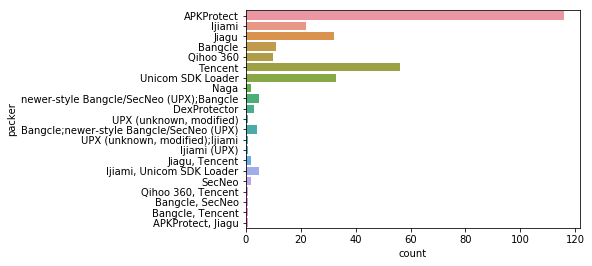

In [15]:
ax = sns.countplot(y="packer", data=train_packer_df)
figure = ax.get_figure()    
figure.savefig(os.path.join(BASE_DIR,"manifest_packer.pdf"), dpi=1000, bbox_inches='tight')

In [203]:
from collections import Counter
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import mutual_info_classif
OUTPUT_MANIFEST_MD = os.path.join(MANIFEST_DIR, "1train_md_manifest.json")

mutual_dict = {}

if os.path.isfile(OUTPUT_MANIFEST_MD):
    with open(OUTPUT_MANIFEST_MD, 'r') as f:
        mutual_dict = json.load(f)
else:
    for p in train_packer_df.packerizer.unique():
        Xtrain = []
        ytrain = []
        p_df = train_packer_df[train_packer_df['packerizer'] == p]
        collect_num = len(p_df.index)
        print("Packer: %s. Num: %d" % (p,collect_num))
        if collect_num < 10:
            continue
        for index, row in p_df.iterrows():
            counts = Counter(row['manifest'])
            fvector = dict(counts)
            Xtrain.append(fvector)
            ytrain.append(row['packer'])
        dv = DictVectorizer()
        X_vec = dv.fit_transform(Xtrain)
        feature_scores = mutual_info_classif(X_vec, ytrain)
        names = []
        for score, fname in sorted(zip(feature_scores, dv.get_feature_names()), reverse=True)[:10]:
            names.append(fname)
        mutual_dict[p] = names
    #with open(OUTPUT_MANIFEST_MD, 'w') as f:
    #    json.dump(mutual_dict, f)
print(mutual_dict.keys())

Packer: APKProtect. Num: 117
Packer: Ijiami. Num: 29
Packer: Jiagu. Num: 34
Packer: Bangcle. Num: 22
Packer: Qihoo 360. Num: 11
Packer: Tencent. Num: 56
Packer: Unicom SDK Loader. Num: 33
Packer: Naga. Num: 2
Packer: DexProtector. Num: 3
Packer: UPX (unknown, modified). Num: 1
Packer: SecNeo. Num: 2
dict_keys(['Unicom SDK Loader', 'Bangcle', 'Ijiami', 'APKProtect', 'Jiagu', 'Qihoo 360', 'Tencent'])


In [204]:
match_count = 0
out_df = pd.DataFrame(columns=[
    'md5', 'tested', 'predict'
])
PREDICT_FILE = os.path.join(MANIFEST_DIR, "predict_integrated_output.pickle")
if os.path.isfile(PREDICT_FILE):
    with open(PREDICT_FILE, "rb") as f:
        out_df = pd.read_pickle(f)
else:
    for index, row in test_packer_df.iterrows():
        counts = Counter(row['manifest'])
        fvector = dict(counts)
        matched = 0
        md5_f = row['md5']
        tested = row['packerizer']
        matched_str = None
        for p,m in mutual_dict.items():
            ytrain = []
            ytrain.append(row['packer'])
            comXTrain = []
            comXTrain.append(fvector)
            counts2 = Counter(m)
            fvector2 = dict(counts2)
            comXTrain.append(fvector2)
            ytrain.append(p)
            dv = DictVectorizer()
            X_vec = dv.fit_transform(comXTrain)
            feature_scores = mutual_info_classif(X_vec, ytrain)
            matched = 0
            for score, fname in sorted(zip(feature_scores, dv.get_feature_names()), reverse=True)[:10]:
                if score != 0.6931471805599453:
                    matched += 1
            if matched > 0:
                if matched_str is None:
                    matched_str = p
                else:
                    matched_str += "," + p 
        row = {
            'md5': md5_f,
            'tested': tested,
            'predict': matched_str
        }
        out_df = out_df.append(row, ignore_index=True)
print(out_df)

                                  md5                   tested  \
0    1de0c33ad57388d70e260f8ef45ec51a               APKProtect   
1    16a9387df5d3abdf4d2ee739d34b9ee4                  Tencent   
2    f34be8c8913dbfef61dbf4df652d38e1               APKProtect   
3    65b0e4a67aa9d6e8db88d4634497547c                    Jiagu   
4    f3771520d33f5121e4d8ccc97a6c6d86               APKProtect   
5    ecc87acfe04b0c60f00c4a129215b0e9                  Bangcle   
6    a6aec0e29dfcf7d9b6e06a62db28af63        Unicom SDK Loader   
7    0acbe34e6b9fe4e46378774edf843a81               APKProtect   
8    b465661fbae48cdabdf04374a6dfc36e                   Ijiami   
9    818582bee441ffb7c8e1e536f628b343                   Ijiami   
10   c9802a53a8c6fdf2b699f4c3313676f2                    Jiagu   
11   0bb05f22463b6656da43f4e04b431d25               APKProtect   
12   9162482fa0b82ff97d74028e030e9711               APKProtect   
13   5ee36d4b4c2674302d4df4622d5ddf99               APKProtect   
14   f694b

In [205]:
matched_df = out_df[out_df['tested'] == out_df['predict']]
non_match = out_df[out_df['tested'] != out_df['predict']]
print("Non-Matched: %d" % len(non_match.md5.unique()))
print(" + Not in dict: %d" % len(non_match[~non_match['tested'].isin(mutual_dict.keys())].md5.unique()))
print(" + Not matched: %d" % len(non_match[non_match['tested'].isin(mutual_dict.keys())].md5.unique()))
non_matched_in_dict = non_match[non_match['tested'].isin(mutual_dict.keys())]

predict_contain_test = 0
for index, row in non_matched_in_dict.iterrows():
    if row['predict'] is not None:
        if row['tested'] in row['predict']:
            predict_contain_test += 1
            
print(" + Test result in predicted: %d " % predict_contain_test)
print("All: %d" % len(out_df.md5.unique()))
print("Matched: %d" % len(matched_df.md5.unique()))

#print(non_match[~non_match['tested'].isin(mutual_dict.keys())])
#print(mutual_dict.keys())
#print(non_match)

precision = (len(matched_df.md5.unique())/len(out_df.md5.unique()))*100
print("Precision: %s" % precision)

Non-Matched: 19
 + Not in dict: 7
 + Not matched: 12
 + Test result in predicted: 6 
All: 196
Matched: 177
Precision: 90.3061224489796


In [206]:
match_count = 0
out_df = pd.DataFrame(columns=[
    'md5', 'tested', 'predict'
])

PREDICT_NORMAL_FILE = os.path.join(MANIFEST_DIR, "predict_normal_integrated_output.pickle") # all
PREDICT_NORMAL_FILE_TN = os.path.join(MANIFEST_DIR, "predict_normal_tn_integrated_output.pickle") # True Negative
if os.path.isfile(PREDICT_NORMAL_FILE):
    with open(PREDICT_NORMAL_FILE, "rb") as f:
        out_df = pd.read_pickle(f)
else:
    normal_df = df[df['packer'] == 0]
    for index, row in normal_df.iterrows():
        counts = Counter(row['manifest'])
        fvector = dict(counts)
        matched = 0
        md5_f = row['md5']
        tested = None
        matched_str = None
        for p,m in mutual_dict.items():
            ytrain = []
            ytrain.append(row['packer'])
            comXTrain = []
            comXTrain.append(fvector)
            counts2 = Counter(m)
            fvector2 = dict(counts2)
            comXTrain.append(fvector2)
            ytrain.append(p)
            dv = DictVectorizer()
            X_vec = dv.fit_transform(comXTrain)
            feature_scores = mutual_info_classif(X_vec, ytrain)
            matched = 0
            for score, fname in sorted(zip(feature_scores, dv.get_feature_names()), reverse=True)[:10]:
                if score != 0.6931471805599453:
                    matched += 1
            if matched > 0:
                if matched_str is None:
                    matched_str = p
                else:
                    matched_str += "," + p 
        row = {
            'md5': md5_f,
            'tested': tested,
            'predict': matched_str
        }
        out_df = out_df.append(row, ignore_index=True)


In [225]:
md5_normal_list = []
with open(os.path.join(BASE_DIR, "md5_list_normal_integrated.pickle")) as data_file:    
        md5_normal_list = json.load(data_file)

final_df = pd.DataFrame()
for md5 in md5_normal_list:
    target_normal_df = out_df[out_df['md5'] == md5]
    final_df = final_df.append(target_normal_df, ignore_index=True)
    
none_df = final_df[final_df['predict'].isnull()]
not_predict = len(none_df.md5.unique())
total_normal = len(final_df.md5.unique())
n_precision = not_predict/total_normal
print("Total: %d" % total_normal)
print("True Negative: %d" % not_predict)
print("Precision:%s" % n_precision)

Total: 201
True Negative: 195
Precision:0.9701492537313433


# DEBUG

###  DEBUG

from collections import Counter

counter_dict = {}
for p in train.packerizer.unique():
    p_df = train[train['packerizer'] == p]
    collect_num = len(p_df.index)
    if collect_num < 10:
        continue
    min_threshold = collect_num/4
    total_man = []
    for index, row in p_df.iterrows():
        total_man += row['manifest']
    counts = Counter(total_man)
    top_words = {x : counts[x] for x in counts if counts[x] >= min_threshold}
    counter_dict[p] = list(top_words.keys())
print(counter_dict)

### DEBUG

from collections import Counter

from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import f_classif

f_dict = {}
for p in train.packerizer.unique():
    Xtrain = []
    ytrain = []
    p_df = train[train['packerizer'] == p]
    collect_num = len(p_df.index)
    if collect_num < 10:
        continue
    for index, row in p_df.iterrows():
        counts = Counter(row['manifest'])
        fvector = dict(counts)
        Xtrain.append(fvector)
        ytrain.append(row['packer'])
    dv = DictVectorizer()
    X_vec = dv.fit_transform(Xtrain)
    feature_scores = f_classif(X_vec, ytrain)[0]
    names = []
    for score, fname in sorted(zip(feature_scores, dv.get_feature_names()), reverse=True)[:10]:
        names.append(fname)
    f_dict[p] = names

### DEBUG

from collections import Counter

from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import chi2

chi_dict = {}
for p in train.packerizer.unique():
    Xtrain = []
    ytrain = []
    p_df = train[train['packerizer'] == p]
    collect_num = len(p_df.index)
    if collect_num < 10:
        continue
    for index, row in p_df.iterrows():
        counts = Counter(row['manifest'])
        fvector = dict(counts)
        Xtrain.append(fvector)
        ytrain.append(row['packer'])
    dv = DictVectorizer()
    X_vec = dv.fit_transform(Xtrain)
    feature_scores = chi2(X_vec, ytrain)[0]
    names = []
    print("Packer: %s" % p)
    for score, fname in sorted(zip(feature_scores, dv.get_feature_names()), reverse=True)[:10]:
        if len(fname) > 0 and not np.isnan(score):
            print("%s:%s" % (fname, score))
            names.append(fname)
    chi_dict[p] = names